### 📘 Make More v5.0 — WaveNet-Inspired Modular Neural Language Model

#### 🔍 Overview
In version 5.0, the architecture is redesigned to resemble WaveNet, a powerful autoregressive model originally developed for audio generation. This version focuses on composability and hierarchical processing using small, modular components.

#### Key Enhancements:
🔧 Introduced modular building blocks (Embedding, FlattenConsecutive, Sequential) similar to PyTorch's nn.Module.

🧠 Adopted WaveNet-inspired input batching: instead of flattening the context window, inputs are processed in structured groups (e.g., bigrams).

📊 Improved loss curve visualization by averaging over 1000-iteration blocks for clarity.


🌊 WaveNet-Inspired Architecture
Instead of a traditional MLP taking flattened inputs, this version introduces structured grouping, simulating 1D convolution over character embeddings:
``` python
# Input Shape Example:
e = torch.randn(4, 4, 20)  # 4 examples, 4 context tokens, each with 20-dimensional embedding

# Forward transformation example:
out = e @ torch.randn(20, 200) + torch.randn(200)
```
This simulates a stack of linear layers processing local patterns (like a bigram or trigram) before global flattening.

Motivation:
Preserves temporal order and local structure before combining into global features.

Mimics dilated convolutional behavior of WaveNet.

<img src="Transformers/images/img.png">

📉 Loss Visualization
Instead of plotting raw loss per step (which is noisy), the training loss is smoothed by averaging over blocks of 1000 steps:

Why this matters:
Easier to interpret long-term trends.

Highlights overfitting, underfitting, or learning plateaus more clearly.



### Summary of Improvements

| Feature                | Description                                                               |
| ---------------------- | ------------------------------------------------------------------------- |
| 🧱 Modular Blocks      | Custom classes for embedding, sequential logic, and structured reshaping  |
| 🌊 WaveNet-style Input | Restructured input as grouped bigrams/trigrams instead of full flattening |
| 🔬 Hierarchical Depth  | Supports stacking multiple `FlattenConsecutive` + Linear layers           |
| 📉 Loss Visualization  | Improved clarity using averaged loss over intervals                       |


In [1]:

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from networkx.classes import non_edges
from sympy import hermite_prob
from torch import nn
# from Transformers.NanoGPT import vocab_size
%matplotlib inline


In [2]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# Building the Dataset
block_size = 8
context = [0] * block_size


def build_datasets(words):
    X , Y = [] , []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("X:" , X ,  "Y:" , Y)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(0)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_datasets(words[:n1])  # 80% of Xtr
Xdev, Ydev = build_datasets(words[n1:n2]) # 10%
Xte, Yte = build_datasets(words[n2:]) # 10%

print(f'Xtr: {Xtr.shape}, Ytr: {Ytr.shape}')
print(f'Xdev: {Xdev.shape}, Ydev: {Ydev.shape}')
print(f'Xte: {Xte.shape}, Yte: {Yte.shape}')



Xtr: torch.Size([182594, 8]), Ytr: torch.Size([182594])
Xdev: torch.Size([22846, 8]), Ydev: torch.Size([22846])
Xte: torch.Size([22706, 8]), Yte: torch.Size([22706])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> s
.......s --> a
......sa --> n
.....san --> i
....sani --> i
...sanii --> .
........ --> r
.......r --> h
......rh --> y
.....rhy --> s
....rhys --> o
...rhyso --> n
..rhyson --> .
........ --> l
.......l --> i
......li --> d
.....lid --> a
....lida --> .
........ --> g
.......g --> e


In [7]:
#---------------------------------Building Blocks for reusing the classes ---------------------------------------------------
# -------Linear Layer -------------------------------------------------------------------------------------------------------
class Linear:

    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features), generator=g)/ (in_features)**0.5
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
# -------Batch Norm Layer ---------------------------------------------------------------------------------------------------

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training =True
        # parameters (which are trained )
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trainned with momentum updating)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate forward pass
        if self.training: # note pytorch expects (N, C, L) , L is sequence length, but we implement (N, L, C)
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
          with torch.no_grad():
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
# ---- TanH layer =----------------------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  # -----Embedding Layer ----------------------------------------------------------------------------------------------------

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

#----------_Flatten----------------------------------------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)

        if x.shape[1] ==  1:
            x = x.squeeze(1)
        self.out = x

        return self.out

    def parameters(self):
        return []
#----------Sequential -----------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [8]:
torch.manual_seed(42); # seed rng for reproducibility

In [10]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128  # the number of neurons in the hidden layer of the MLP we use this 68 to maintain same parameters from before network
tuple_size = 2
g = torch.Generator().manual_seed(2147434123517) # for reproducibility

# ---------------------------Network-------------------
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(tuple_size), Linear(n_embd * tuple_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(tuple_size), Linear(n_hidden * tuple_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(tuple_size), Linear(n_hidden * tuple_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # making the last linear layer less confident
    model.layers[-1].weight *=0.1

#_--------------Parameters------------------------
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True



76579


In [202]:
# lets check the shapes inside our network for just four examples
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0, 10, 21, 10,  8,  1, 18],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  2, 18, 25, 15],
        [ 0,  0,  0,  1, 22,  9, 20,  1]])

In [203]:
for layer in model.layers:
    print(layer.__class__.__name__, ":" , tuple(layer.out.shape))




Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [204]:
# Fixing BatchNorm 1d BUG: current implementation
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True)  # 1, 4, 68
evar = e.var(0, keepdim=True) # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32 , 4, 68
ehat.shape

torch.Size([32, 4, 68])

In [205]:
model.layers[3].running_mean.shape # this is the running mean

torch.Size([1, 1, 128])

In [191]:
# Fixing BatchNorm 1d BUG: updating implementation
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim=True)  # 1, 4, 68
evar = e.var((0,1), keepdim=True) # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32 , 4, 68
evar.shape

torch.Size([1, 1, 68])

torch.Size([1, 4, 68])

In [206]:
output_layer_1 = model.layers[0].out.shape
print(f'output_layer_1: {output_layer_1}')
output_layer_2 = model.layers[1].out.shape
print(f'output_layer_2: {output_layer_2}')
output_layer_3 = model.layers[2].out.shape
print(f'output_layer_1: {output_layer_3}')


output_layer_1: torch.Size([4, 8, 24])
output_layer_2: torch.Size([4, 4, 48])
output_layer_1: torch.Size([4, 4, 128])


In [207]:
# torch matrix multiplication is powerfull so that we can multiply with more dim
# it considers only the last layer
# before dim are consider as a batch
(torch.randn(4, 5, 6, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 6, 200])

In [ ]:
# this is very usefull to introduce a batch dim in our example inorder to pass it as biagram into our wave net
# 1 2 3 4 5 6 7 8
# instead of flatten it as full 8 dim and pass it through network
# we introduce a batches
# (1 2) (3 4) (5 6) (7 8)
#   .     .     .     .
#      .     .     .
#         .     .
#           out


In [208]:
# inorder to obtain this architechture
# 4 examples 4 batches (tuples ) each one with 10 dim
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape


torch.Size([4, 4, 200])

In [209]:
# so inorder to achive this input matrix of [4 4 20], we need to modify out flatten class:
# for now it is considering as :
e = torch.randn(4, 8, 10)
print(e.view(4, -1).shape)
# but we need a tuples of biagram as this :
# (1 2) (3 4) (5 6) (7 8)
# How can we do this ------(As we know the step index slicing in python)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim = 2)
explicit.shape

torch.Size([4, 80])


torch.Size([4, 4, 20])

In [210]:
# this can be done by view also this same values we want
(e.view(4,4, 20) == explicit).all()

tensor(True)

In [211]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3839
  10000/ 200000: 2.5415
  20000/ 200000: 2.2401
  30000/ 200000: 1.7244
  40000/ 200000: 2.2586
  50000/ 200000: 1.6624
  60000/ 200000: 2.0625
  70000/ 200000: 1.9313
  80000/ 200000: 1.9292
  90000/ 200000: 1.9625
 100000/ 200000: 1.8004
 110000/ 200000: 1.8551
 120000/ 200000: 1.7652
 130000/ 200000: 1.8207
 140000/ 200000: 1.7594
 150000/ 200000: 1.7241
 160000/ 200000: 1.8107
 170000/ 200000: 2.0684
 180000/ 200000: 2.0806
 190000/ 200000: 1.3434


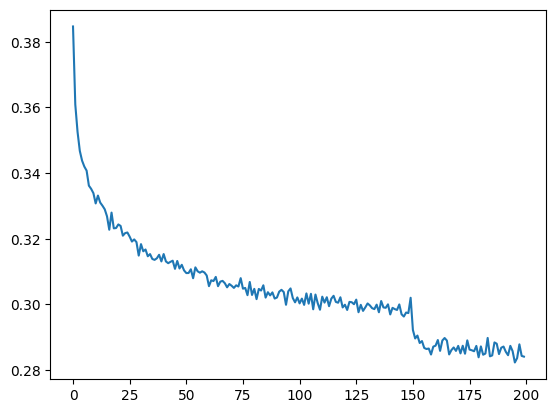

In [196]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [197]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [199]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.910601258277893
val 2.0137016773223877


## 📊 Baseline vs. Hierarchical Model Performance

### 🔹 Baseline Model (Context Size = 8)
- **Training Loss**: `2.0024`
- **Validation Loss**: `~2.0`

---

### 🔸 After Hierarchical Structure (WaveNet-inspired)
- **Training Loss**: `1.9393`
- **Validation Loss**: `2.0189`

---

### 🔧 With `hlayer = 68` and `dim = 10`
- **Training Loss**: `1.9393`
- **Validation Loss**: `2.0189`


## performance log
- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027

In [90]:
# sample from the model
g = torch.Generator().manual_seed(2147483657)

for _ in range(20):
    out = []
    # intializing with all zeros [0,0,0] (...)
    context = [0] * block_size
    while True:
        # forward pass to the nerual network
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sampling from the distribution using multinomial
        ix = torch.multinomial(probs, num_samples=1, generator=g)

        # shifting the context window ... ---> e ==> ..e --> m
        context = context[1:] + [ix]
        out.append(ix.item())
        # if the sample is special token (.) break
        if ix ==0:
            break
    # decoding the output embeddings
    print(''.join(itos[i] for i in out))

carman.
ambrie.
khismi.
xilah.
khalani.
emmahnee.
dellyn.
jarqui.
nermari.
chaiir.
kaleigh.
hamoni.
jaquinn.
sulina.
livabi.
wazella.
jarynn.
jaxeelin.
demed.
ediia.


### 📦 Next Steps for v6.0

- 📈 Add residual connections to emulate full WaveNet

- 🌀 Implement dilated convolutions for larger receptive fields

- 🧠 Incorporate attention or gating for dynamic feature control

- 🧪 Experiment with dropout or layer normalization for regularization

